### Imports

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import librosa         
import librosa.display
from IPython.display import Audio
import IPython.display
from scipy.fftpack import fft
import scipy
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
%matplotlib inline
from sklearn.metrics import f1_score

# 1. Download the Dataset and Understand the Format

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
google_drive = GoogleDrive(gauth)
downloaded = google_drive.CreateFile({'id':"1v4zSFOdfbFyMFalPVB95M0atJDryKRYb"})
downloaded.GetContentFile('Crema.zip')        
!unzip -qq /content/Crema.zip -d /content/dataset

In [ ]:
path = "/content/dataset/Crema/"
crema_directory = os.listdir(path)

In [ ]:
emotions = []
file_path = []

In [ ]:
for file in crema_directory:
  file_path.append(path + file)
  emotion = file.split('_')
  if emotion[2] == 'SAD':
      emotions.append('sad')
  elif emotion[2] == 'ANG':
      emotions.append('angry')
  elif emotion[2] == 'DIS':
      emotions.append('disgust')
  elif emotion[2] == 'FEA':
      emotions.append('fear')
  elif emotion[2] == 'HAP':
      emotions.append('happy')
  elif emotion[2] == 'NEU':
      emotions.append('neutral')
  else:
      emotions.append('unknown emotion')

In [ ]:
Emotions_df = pd.DataFrame(emotions, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([path_df, Emotions_df], axis=1)
Crema_df.head()

,Path,Emotion
0,/content/dataset/Crema/1035_ITS_SAD_XX.wav,sad
1,/content/dataset/Crema/1028_IWW_HAP_XX.wav,happy
2,/content/dataset/Crema/1010_TIE_ANG_XX.wav,angry
3,/content/dataset/Crema/1022_IWW_DIS_XX.wav,disgust
4,/content/dataset/Crema/1086_DFA_DIS_XX.wav,disgust


In [ ]:
Crema_df.shape

(7442, 2)

In [ ]:
Crema_df.dtypes

Path       object
Emotion    object
dtype: object

In [ ]:
Crema_df['Emotion'].value_counts()

sad        1271
happy      1271
angry      1271
disgust    1271
fear       1271
neutral    1087
Name: Emotion, dtype: int64

In [ ]:
Crema_df['Emotion'].replace(['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral'],
                        [0, 1, 2, 3, 4, 5], inplace=True)

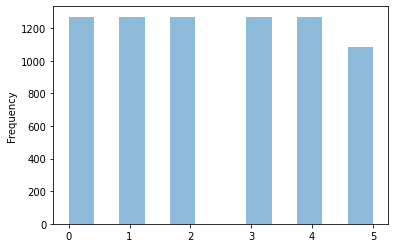

In [ ]:
Crema_df['Emotion'].plot.hist(bins=12, alpha=0.5)

In [ ]:
dic = {0 : 'sad',
        1 : 'angry',
        2 : 'disgust',
        3 : 'fear',
        4 : 'happy',
        5 : 'neutral'}

In [ ]:
def plot_waveform(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 5))
    plt.title('Waveplot for {} emotion'.format(dic[emotion].upper()), size=15)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.show()
def spectrogram(data, sampling_rate, emotion):
    X = librosa.stft(data)                      # stft function converts the data into short term fourier transform, we're working in frequency domain
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 5))
    plt.title('Spectrogram for  {} emotion'.format(dic[emotion].upper()), size=15)
    p=librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')   
    plt.colorbar()
    return p
def load_audio(path):
  data, sampling_rate = librosa.load(path)
  plot_waveform(data, sampling_rate, emotion)
  p=spectrogram(data, sampling_rate, emotion)
  print(f'Sampling rate: {sampling_rate}')
  IPython.display.display(Audio(path))
  return p   

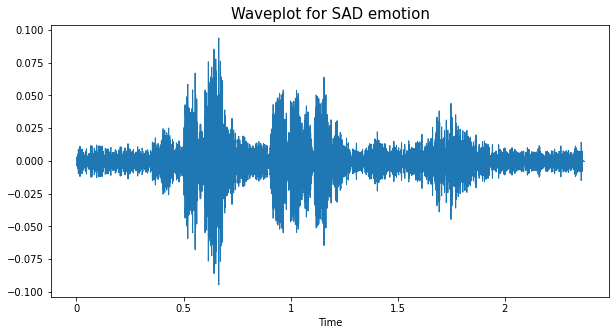

Sampling rate: 22050


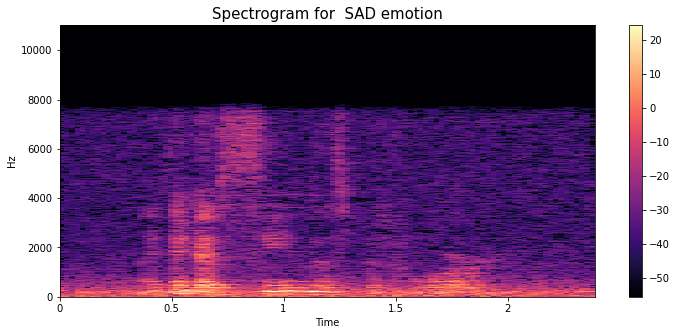

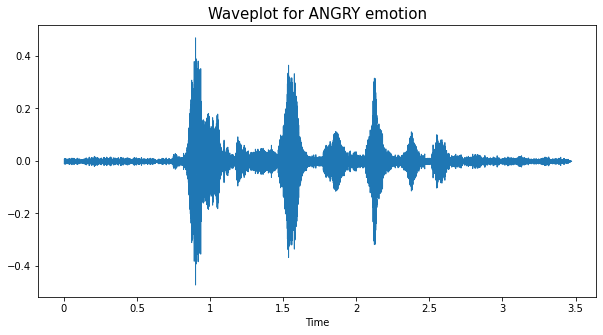

Sampling rate: 22050


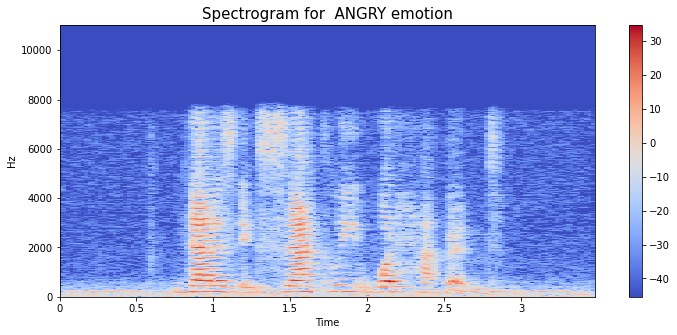

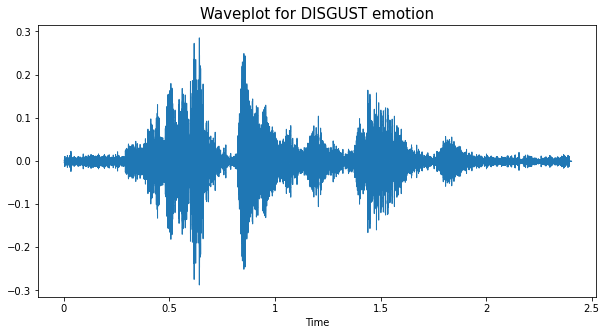

Sampling rate: 22050


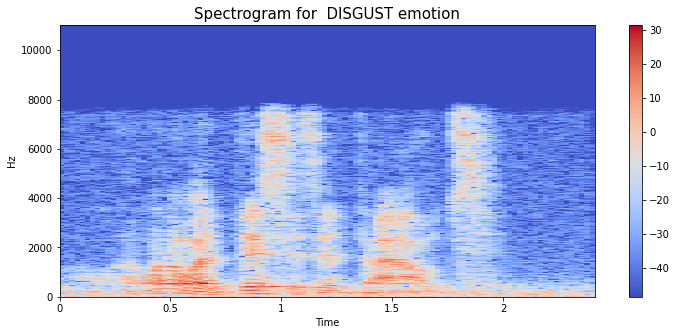

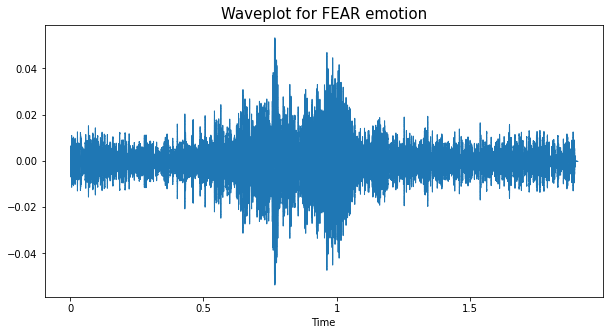

Sampling rate: 22050


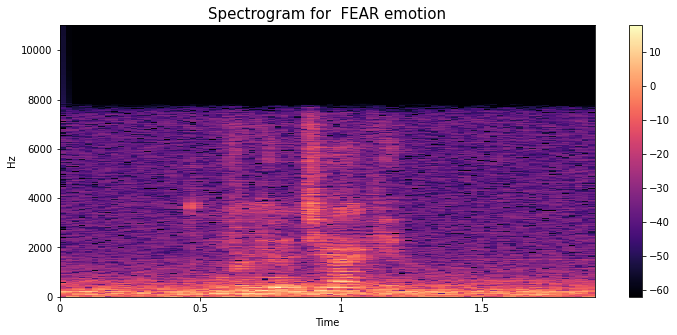

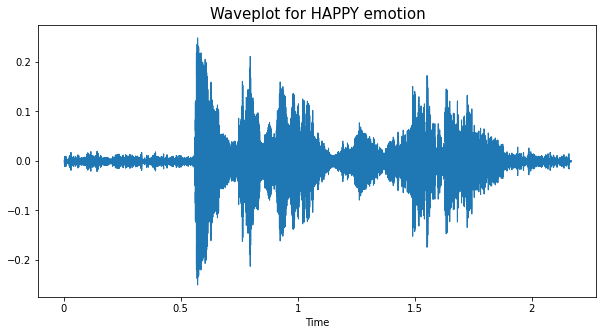

Sampling rate: 22050


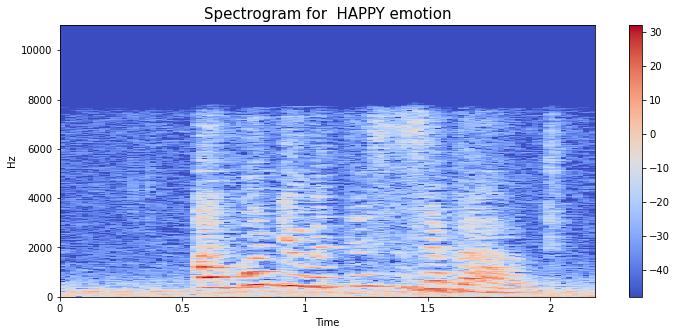

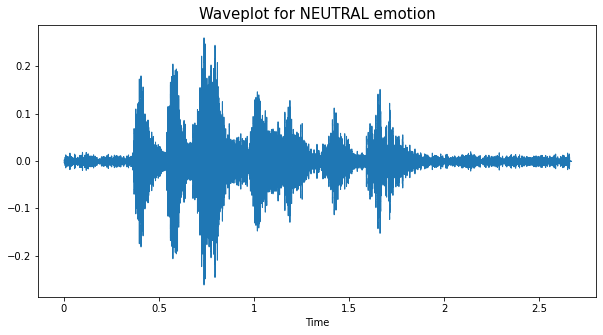

Sampling rate: 22050


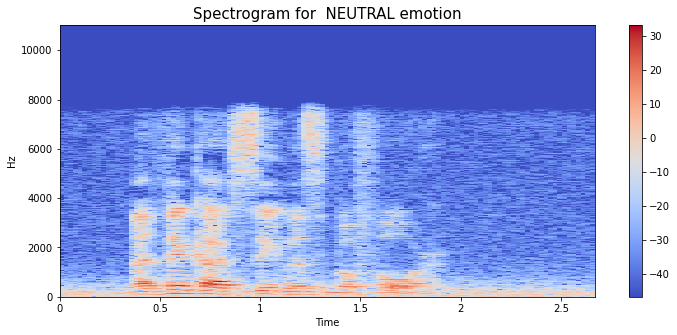

In [ ]:

emotions = [0, 1, 2, 3, 4, 5]
for emotion in emotions:
  path = np.array(Crema_df.Path[Crema_df.Emotion==emotion])[0]
  p=load_audio(path)
  print(p)

In [ ]:
train_val_df, test_df = train_test_split(Crema_df, test_size=0.05, random_state=32)

In [ ]:
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=32)

In [ ]:
train_df['Emotion'].value_counts()

2    1100
3    1086
0    1085
4    1080
1    1069
5     942
Name: Emotion, dtype: int64

# 2. Create the Feature Space

#### A - work on time domain or frequency domain

In [ ]:
params = {'batch_size': 32,
          'num_workers': 2}


In [ ]:
class TimeDomainDataset(torch.utils.data.Dataset):
  def __init__(self, df):
        self.df = df

  def __len__(self):
        return len(self.df)

  def __getitem__(self, index):
        max_shape = (1, 314)
        row = self.df.iloc[index]
        sample, sr = librosa.load(row['Path'], sr=None)
        X_zcr = librosa.feature.zero_crossing_rate(sample)
        X_rms = librosa.feature.rms(sample)

        X = np.concatenate((X_zcr, X_rms), axis=None)
        X = np.expand_dims(X, axis=0)
        padded_array = np.zeros(max_shape)
        shape = np.shape(X)
        padded_array[:shape[0],:shape[1]] = X
        X = padded_array
        
        y = row['Emotion']
        return X, y

In [ ]:
training_1D_set = TimeDomainDataset(train_df)
testing_1D_set = TimeDomainDataset(test_df)
validating_1D_set = TimeDomainDataset(val_df)

In [ ]:
training_generator_1D = torch.utils.data.DataLoader(training_1D_set, **params)
testing_generator_1D = torch.utils.data.DataLoader(testing_1D_set, **params)
validating_generator_1D = torch.utils.data.DataLoader(validating_1D_set, **params)

In [ ]:
for x, y in training_generator_1D:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 1, 314])
torch.Size([32])


#### B - Convert the audio waveform to mel spectrogram

In [ ]:
class SpectrogramDataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    max_shape = (128, 157)
    row = self.df.iloc[index]
    sample, sr = librosa.load(row['Path'], sr=None)
    X = librosa.feature.melspectrogram(sample, sr=sr)
    padded_array = np.zeros(max_shape)
    shape = np.shape(X)
    padded_array[:shape[0],:shape[1]] = X
    X = padded_array
    X = torch.from_numpy(np.expand_dims(X, axis=0)).float()
    y = row['Emotion']
    return X, y

In [ ]:
training_2D_set = SpectrogramDataset(train_df)
testing_2D_set = SpectrogramDataset(test_df)
validating_2D_set = SpectrogramDataset(val_df)

In [ ]:
training_generator_2D = torch.utils.data.DataLoader(training_2D_set, **params)
testing_generator_2D = torch.utils.data.DataLoader(testing_2D_set, **params)
validating_generator_2D = torch.utils.data.DataLoader(validating_2D_set, **params)

In [ ]:
for x, y in training_generator_2D:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 1, 128, 157])
torch.Size([32])


# 3. Building the Model

In [ ]:
class CNNBlock1D(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(CNNBlock1D, self).__init__()
    self.cnn1d = nn.Conv1d(in_channel, out_channel, kernel_size=5, stride=1)
    self.max_p_1d = nn.MaxPool1d(kernel_size=5, stride=2)

  def forward(self, data):
    x = self.cnn1d(data)
    x = F.relu(x)
    x = self.max_p_1d(x)
    return x

In [ ]:
class Model1D(nn.Module):

  def __init__(self):
    super(Model1D, self).__init__()
    self.b1 = CNNBlock1D(1, 512)
    self.b2 = CNNBlock1D(512, 512)
    self.b3 = CNNBlock1D(512, 128)
    self.fc1 = nn.Linear(4224, 256)
    self.fc2 = nn.Linear(256, 6)
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, data):
    x = self.b1(data)
    x = self.dropout(x)
    x = self.b2(x)
    x = self.dropout(x)
    x = self.b3(x)
    x = x.reshape(x.size(0), -1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.softmax(x)
    return x


In [ ]:
def train_fn(model, data_loader, optimizer, loss_fn):
  total_loss = 0
  total_acc = 0
  model.train()

  for data in tqdm(data_loader):
    sound, label = data
    sound, label = sound.to(DEVICE), label.to(DEVICE)
    model.train()
    optimizer.zero_grad()
    y_pred = model(sound.float())
    loss = loss_fn(y_pred, label)
    loss.backward()
    optimizer.step()

    _, y_pred = torch.max(y_pred, dim = 1) 
    correct_pred = (label == y_pred).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    
    total_acc += acc
    total_loss += loss

  return total_loss / len(data_loader), total_acc / len(data_loader)

In [ ]:
def eval_fn(model, data_loader, loss_fn):
  total_loss = 0
  total_acc = 0
  model.eval()
  with torch.no_grad():
    for data in tqdm(data_loader):
      sound, label = data
      sound, label = sound.to(DEVICE), label.to(DEVICE)
      y_pred = model(sound.float())
      loss = loss_fn(y_pred, label)

      _, y_pred = torch.max(y_pred, dim = 1) 
      correct_pred = (label == y_pred).float()
      acc = correct_pred.sum() / len(correct_pred)
      acc = torch.round(acc * 100)
      
      total_acc += acc
      total_loss += loss

  return total_loss / len(data_loader), total_acc / len(data_loader)

In [ ]:
def run_model(model, optimizer, criterion, train, val, patience):
  best_loss = np.inf
  last_loss = 0
  trigger_times = 0
  for i in range(EPOCHS):
    train_loss, train_acc = train_fn(model, train, optimizer, criterion)
    val_loss, val_acc = eval_fn(model, val, criterion)
    print(f'EPOCH : {i+1} - Train acc : {train_acc} - Train loss : {train_loss}')
    print(f'EPOCH : {i+1} - Val acc : {val_acc} - Val loss : {val_loss}')

  # Early stopping
    if val_loss > last_loss:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            return model
    else:
        trigger_times = 0

    last_loss = val_loss

    if val_loss < best_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      print('WEIGHT_ARE_SAVED')
      best_loss = val_loss
  return model

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
LR = 1e-3

In [ ]:
DEVICE

device(type='cuda', index=0)

In [ ]:
model = Model1D()
model = model.to(DEVICE)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
m1_1d = run_model(model, optimizer, criterion, training_generator_1D, validating_generator_1D, 5)

  0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 1 - Train acc : 23.542713165283203 - Train loss : 1.7547320127487183
EPOCH : 1 - Val acc : 35.130435943603516 - Val loss : 1.6899124383926392
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 2 - Train acc : 29.723617553710938 - Train loss : 1.7172293663024902
EPOCH : 2 - Val acc : 33.69565200805664 - Val loss : 1.6814748048782349
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 3 - Train acc : 31.432161331176758 - Train loss : 1.7003448009490967
EPOCH : 3 - Val acc : 38.5217399597168 - Val loss : 1.6582237482070923
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 4 - Train acc : 33.417083740234375 - Train loss : 1.6859859228134155
EPOCH : 4 - Val acc : 35.08695602416992 - Val loss : 1.6845120191574097


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 5 - Train acc : 34.73869323730469 - Train loss : 1.677262783050537
EPOCH : 5 - Val acc : 41.043479919433594 - Val loss : 1.6363935470581055
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 6 - Train acc : 35.145729064941406 - Train loss : 1.6726207733154297
EPOCH : 6 - Val acc : 40.4782600402832 - Val loss : 1.642333984375


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 7 - Train acc : 36.30653381347656 - Train loss : 1.6637858152389526
EPOCH : 7 - Val acc : 38.21739196777344 - Val loss : 1.6517120599746704


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 8 - Train acc : 37.477386474609375 - Train loss : 1.653416395187378
EPOCH : 8 - Val acc : 38.91304397583008 - Val loss : 1.633485198020935
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 9 - Train acc : 38.59296417236328 - Train loss : 1.6471986770629883
EPOCH : 9 - Val acc : 43.08695602416992 - Val loss : 1.6150312423706055
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 10 - Train acc : 37.884422302246094 - Train loss : 1.6492090225219727
EPOCH : 10 - Val acc : 41.434783935546875 - Val loss : 1.6290563344955444


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 11 - Train acc : 38.21607971191406 - Train loss : 1.6471987962722778
EPOCH : 11 - Val acc : 33.21739196777344 - Val loss : 1.6970704793930054


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 12 - Train acc : 38.37186050415039 - Train loss : 1.6447635889053345
EPOCH : 12 - Val acc : 41.65217590332031 - Val loss : 1.6353473663330078


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 13 - Train acc : 39.72361755371094 - Train loss : 1.6363407373428345
EPOCH : 13 - Val acc : 38.39130401611328 - Val loss : 1.6296802759170532


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 14 - Train acc : 40.25125503540039 - Train loss : 1.6310397386550903
EPOCH : 14 - Val acc : 43.86956787109375 - Val loss : 1.6011499166488647
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 15 - Train acc : 39.44221115112305 - Train loss : 1.632219672203064
EPOCH : 15 - Val acc : 40.60869598388672 - Val loss : 1.6335105895996094


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 16 - Train acc : 40.34170913696289 - Train loss : 1.6293693780899048
EPOCH : 16 - Val acc : 38.869564056396484 - Val loss : 1.633700966835022


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 17 - Train acc : 40.743717193603516 - Train loss : 1.6249399185180664
EPOCH : 17 - Val acc : 41.173912048339844 - Val loss : 1.6173893213272095


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 18 - Train acc : 40.97990036010742 - Train loss : 1.6232401132583618
EPOCH : 18 - Val acc : 45.739131927490234 - Val loss : 1.5922770500183105
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 19 - Train acc : 41.02009963989258 - Train loss : 1.6203421354293823
EPOCH : 19 - Val acc : 45.4782600402832 - Val loss : 1.5769505500793457
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 20 - Train acc : 42.32663345336914 - Train loss : 1.6132487058639526
EPOCH : 20 - Val acc : 40.39130401611328 - Val loss : 1.6240158081054688


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 21 - Train acc : 41.090450286865234 - Train loss : 1.620921015739441
EPOCH : 21 - Val acc : 42.91304397583008 - Val loss : 1.6058341264724731


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 22 - Train acc : 42.36180877685547 - Train loss : 1.611029028892517
EPOCH : 22 - Val acc : 44.39130401611328 - Val loss : 1.588534951210022


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 23 - Train acc : 42.09547805786133 - Train loss : 1.6116474866867065
EPOCH : 23 - Val acc : 44.826087951660156 - Val loss : 1.5903263092041016


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 24 - Train acc : 42.698490142822266 - Train loss : 1.606523871421814
EPOCH : 24 - Val acc : 44.69565200805664 - Val loss : 1.5869389772415161


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 25 - Train acc : 42.85929489135742 - Train loss : 1.6060841083526611
EPOCH : 25 - Val acc : 45.60869598388672 - Val loss : 1.5820636749267578


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 26 - Train acc : 42.23617935180664 - Train loss : 1.611310601234436
EPOCH : 26 - Val acc : 46.130435943603516 - Val loss : 1.5827984809875488


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 27 - Train acc : 42.81407165527344 - Train loss : 1.604527473449707
EPOCH : 27 - Val acc : 46.173912048339844 - Val loss : 1.5726282596588135
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 28 - Train acc : 43.44221115112305 - Train loss : 1.5977526903152466
EPOCH : 28 - Val acc : 44.4782600402832 - Val loss : 1.5907092094421387


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 29 - Train acc : 43.31658172607422 - Train loss : 1.6009947061538696
EPOCH : 29 - Val acc : 46.65217590332031 - Val loss : 1.57290780544281


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 30 - Train acc : 43.58291244506836 - Train loss : 1.5972752571105957
EPOCH : 30 - Val acc : 45.60869598388672 - Val loss : 1.5847347974777222


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 31 - Train acc : 44.492462158203125 - Train loss : 1.5896193981170654
EPOCH : 31 - Val acc : 44.739131927490234 - Val loss : 1.5900096893310547


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 32 - Train acc : 43.54773712158203 - Train loss : 1.597964882850647
EPOCH : 32 - Val acc : 45.0 - Val loss : 1.5833282470703125


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 33 - Train acc : 43.3366813659668 - Train loss : 1.5992581844329834
EPOCH : 33 - Val acc : 43.56521987915039 - Val loss : 1.5998868942260742


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 34 - Train acc : 44.115577697753906 - Train loss : 1.5921874046325684
EPOCH : 34 - Val acc : 44.39130401611328 - Val loss : 1.5890473127365112


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 35 - Train acc : 44.31658172607422 - Train loss : 1.591256022453308
EPOCH : 35 - Val acc : 45.21739196777344 - Val loss : 1.5817197561264038


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 36 - Train acc : 43.61306381225586 - Train loss : 1.5977189540863037
EPOCH : 36 - Val acc : 42.30434799194336 - Val loss : 1.61393404006958


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 37 - Train acc : 44.89447021484375 - Train loss : 1.5864691734313965
EPOCH : 37 - Val acc : 46.130435943603516 - Val loss : 1.5742619037628174


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 38 - Train acc : 45.92462158203125 - Train loss : 1.5771111249923706
EPOCH : 38 - Val acc : 43.86956787109375 - Val loss : 1.5960739850997925


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 39 - Train acc : 44.97990036010742 - Train loss : 1.5860704183578491
EPOCH : 39 - Val acc : 44.65217590332031 - Val loss : 1.586812138557434


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 40 - Train acc : 45.3366813659668 - Train loss : 1.5819545984268188
EPOCH : 40 - Val acc : 42.91304397583008 - Val loss : 1.5988774299621582


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 41 - Train acc : 45.37688446044922 - Train loss : 1.5816324949264526
EPOCH : 41 - Val acc : 46.130435943603516 - Val loss : 1.5731337070465088


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 42 - Train acc : 44.94974899291992 - Train loss : 1.5851682424545288
EPOCH : 42 - Val acc : 43.65217590332031 - Val loss : 1.6055389642715454


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 43 - Train acc : 45.32160568237305 - Train loss : 1.5818116664886475
EPOCH : 43 - Val acc : 44.5217399597168 - Val loss : 1.5846682786941528


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 44 - Train acc : 45.31658172607422 - Train loss : 1.5829064846038818
EPOCH : 44 - Val acc : 46.30434799194336 - Val loss : 1.5703438520431519
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 45 - Train acc : 44.869346618652344 - Train loss : 1.5851900577545166
EPOCH : 45 - Val acc : 43.739131927490234 - Val loss : 1.5996270179748535


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 46 - Train acc : 45.778892517089844 - Train loss : 1.5785026550292969
EPOCH : 46 - Val acc : 47.08695602416992 - Val loss : 1.572919249534607


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 47 - Train acc : 45.67839050292969 - Train loss : 1.578652024269104
EPOCH : 47 - Val acc : 46.826087951660156 - Val loss : 1.5708283185958862


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 48 - Train acc : 45.849246978759766 - Train loss : 1.5769283771514893
EPOCH : 48 - Val acc : 45.65217590332031 - Val loss : 1.582297444343567


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 49 - Train acc : 45.4522590637207 - Train loss : 1.5793832540512085
EPOCH : 49 - Val acc : 44.91304397583008 - Val loss : 1.582005262374878


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 50 - Train acc : 47.150753021240234 - Train loss : 1.5652354955673218
EPOCH : 50 - Val acc : 45.34782791137695 - Val loss : 1.5811437368392944


In [ ]:
PATH = '/content/best_model.pt'

In [ ]:
m1_1d = Model1D()
m1_1d.load_state_dict(torch.load(PATH))
m1_1d = m1_1d.to(DEVICE)

In [ ]:
test_loss, test_acc = eval_fn(m1_1d, testing_generator_1D, criterion)
print(f'Test acc : {test_acc} - Test loss : {test_loss}')

  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test acc : 47.41666793823242 - Test loss : 1.5679497718811035


In [ ]:
class CNNBlock2D(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(CNNBlock2D, self).__init__()
    self.cnn2d = nn.Conv2d(in_channel, out_channel, kernel_size=5, stride=1)  
    self.max_p_2d = nn.MaxPool2d(kernel_size=5, stride=2)

  def forward(self, data):
    x = self.cnn2d(data)
    x = F.relu(x)
    x = self.max_p_2d(x)
    return x

In [ ]:
class Model2D(nn.Module):

  def __init__(self):
    super(Model2D, self).__init__()
    self.b1 = CNNBlock2D(1, 512)
    self.b2 = CNNBlock2D(512, 512)
    self.b3 = CNNBlock2D(512, 128)
    self.fc1 = nn.Linear(14976, 256)
    self.fc2 = nn.Linear(256, 6)
    self.dropout = nn.Dropout(0.5)

  def forward(self, data):
    x = self.b1(data)
    x = self.dropout(x)
    x = self.b2(x)
    x = self.dropout(x)
    x = self.b3(x)
    x = x.reshape(x.size(0), -1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.softmax(x)
    return x


In [ ]:
model_2d = Model2D()
model_2d = model_2d.to(DEVICE)

In [ ]:
# pip install torchensemble

In [ ]:
# from torchensemble import VotingClassifier
# model_e = VotingClassifier(
#     estimator=Model2D,
#     n_estimators=5,
#     cuda=False,
# )

# model_e.set_optimizer('SGD', lr=1e-2, weight_decay=5e-3) 
# criterion = nn.CrossEntropyLoss()
# model_e.set_criterion(criterion)
# model_e.fit(train_loader=training_generator_2D, epochs=100,  test_loader=validating_generator_2D)                 

In [ ]:
# def eval(data):
#   total_acc = 0
#   for x,y in tqdm(data):
#     x = x.to
#     accuracy = model.predict(x)
#     _, y_pred = torch.max(y_pred, dim = 1) 
#     correct_pred = (label == y_pred).float()
#     acc = correct_pred.sum() / len(correct_pred)
#     acc = torch.round(acc * 100)
#     total_acc += acc

#   print(f"ACC : {total_acc / len(data)}")
      

In [ ]:
# eval(testing_generator_2D)
# eval(training_generator_2D)
# eval(validating_generator_2D)

In [ ]:
EPOCHS = 20
LR = 1e-2

In [ ]:
optimizer = torch.optim.SGD(model_2d.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
m1_2d = run_model(model_2d, optimizer, criterion, training_generator_2D, validating_generator_2D, 5)

NameError: ignored

In [ ]:
m1_2d = Model2D()
m1_2d.load_state_dict(torch.load(PATH))
m1_2d = m1_2d.to(DEVICE)
test_loss, test_acc = eval_fn(m1_2d, testing_generator_2D, criterion)
print(f'Test acc : {test_acc} - Test loss : {test_loss}')

### Using Tensorflow (keras)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPool1D, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def features_extractor(row):
  max_shape = (1, 314)
  sample, sr = librosa.load(row['Path'], sr=None)
  X_zcr = librosa.feature.zero_crossing_rate(sample)
  X_rms = librosa.feature.rms(sample)

  X = np.concatenate((X_zcr, X_rms), axis=None)
  X = np.expand_dims(X, axis=0)
  padded_array = np.zeros(max_shape)
  shape = np.shape(X)
  padded_array[:shape[0],:shape[1]] = X
  X = padded_array
  X = np.squeeze(X)
  X = np.expand_dims(X, axis=1)
  y = row['Emotion']
  return X, y


In [ ]:
def load_data(df, X, y):
  for index_num,row in tqdm(df.iterrows()):
      x, label =features_extractor(row)
      X.append(x)
      y.append(label)

In [ ]:
X_train = []
y_train = []
load_data(train_df, X_train, y_train)

0it [00:00, ?it/s]

In [ ]:
X_val = []
y_val = []
load_data(val_df, X_val, y_val)

0it [00:00, ?it/s]

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_train.shape

(6362, 314, 1)

In [ ]:
X_test = []
y_test = []
load_data(test_df, X_test, y_test)
X_test = np.array(X_test)
y_test = np.array(y_test)

0it [00:00, ?it/s]

In [ ]:
model=Sequential()
model.add(Conv1D(512, 5, activation='relu'))
model.add(MaxPool1D(5, strides=2))

model.add(Conv1D(512, 5, activation='relu' ))
model.add(MaxPool1D(5, strides=2,))

model.add(Conv1D(128, 5, activation='relu' ))
model.add(MaxPool1D(5, strides=2))

model.add(Flatten())
model.add(Dense(256, activation='relu' ))

model.add(Dense(6,  activation='softmax'))

In [ ]:
num_epochs = 2500
num_batch_size = 32

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True,)

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[es, checkpointer], verbose=1)

Epoch 1/2500
199/199 [==============================] - ETA: 0s - loss: 1.7724 - accuracy: 0.1815
Epoch 1: val_loss improved from inf to 1.71729, saving model to saved_models/audio_classification.hdf5
199/199 [==============================] - 15s 20ms/step - loss: 1.7724 - accuracy: 0.1815 - val_loss: 1.7173 - val_accuracy: 0.1924
Epoch 2/2500
196/199 [============================>.] - ETA: 0s - loss: 1.6831 - accuracy: 0.2624
Epoch 2: val_loss improved from 1.71729 to 1.61836, saving model to saved_models/audio_classification.hdf5
199/199 [==============================] - 3s 18ms/step - loss: 1.6819 - accuracy: 0.2647 - val_loss: 1.6184 - val_accuracy: 0.3395
Epoch 3/2500
199/199 [==============================] - ETA: 0s - loss: 1.6129 - accuracy: 0.3390
Epoch 3: val_loss improved from 1.61836 to 1.56631, saving model to saved_models/audio_classification.hdf5
199/199 [==============================] - 3s 17ms/step - loss: 1.6129 - accuracy: 0.3390 - val_loss: 1.5663 - val_accuracy:

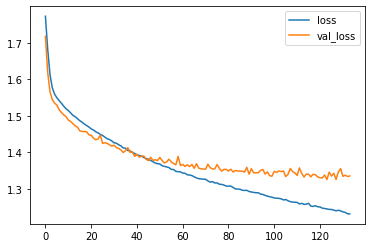

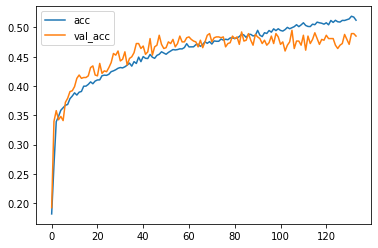

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)

test_acc = sum(y_pred == y_test) / len(y_test)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 46%


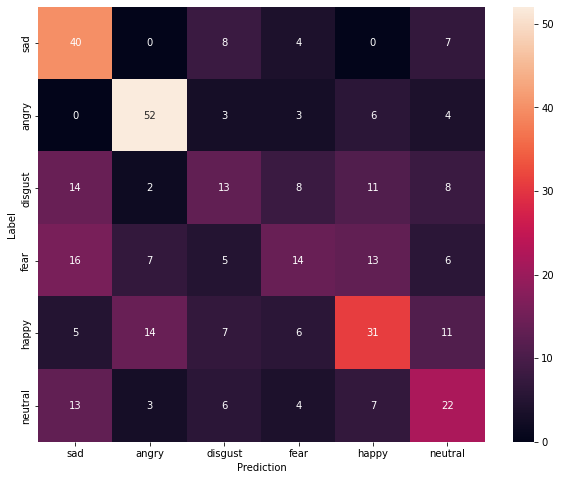

In [ ]:
classes = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
recall_1d = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 1)
precision_1d = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 0)

In [ ]:
print(recall_1d)
print(precision_1d)

[0.6779661  0.76470588 0.26785714 0.21311475 0.54054054 0.47272727]
[0.5        0.75362319 0.34090909 0.46428571 0.43478261 0.43333333]


In [ ]:
print(np.mean(recall_1d))
print(np.mean(precision_1d))

0.4894852823785289
0.48782232260493136


In [ ]:
def features_extractor2D(row):
  max_shape = (128, 157)
  sample, sr = librosa.load(row['Path'], sr=None)
  X = librosa.feature.melspectrogram(sample, sr=sr)
  padded_array = np.zeros(max_shape)
  shape = np.shape(X)
  padded_array[:shape[0],:shape[1]] = X
  X = padded_array
  X = np.expand_dims(X, axis=2)
  y = row['Emotion']
  return X, y


In [ ]:
def load_data2D(df, X, y):
  for index_num,row in tqdm(df.iterrows()):
      x, label =features_extractor2D(row)
      X.append(x)
      y.append(label)

In [ ]:
X_train2D = []
y_train2D = []
load_data2D(train_df, X_train2D, y_train2D)

0it [00:00, ?it/s]

In [ ]:
X_val2D = []
y_val2D = []
load_data2D(val_df, X_val2D, y_val2D)

0it [00:00, ?it/s]

In [ ]:
X_train2D = np.array(X_train2D)
y_train2D = np.array(y_train2D)
X_val2D = np.array(X_val2D)
y_val2D = np.array(y_val2D)
X_val2D.shape

(707, 128, 157, 1)

In [ ]:
X_test2D = []
y_test2D = []
load_data2D(test_df, X_test2D, y_test2D)
X_test2D = np.array(X_test2D)
y_test2D = np.array(y_test2D)

0it [00:00, ?it/s]

In [ ]:
model2D=Sequential()

model2D.add(Conv2D(256, 3, activation='relu'))
model2D.add(MaxPool2D(3, strides=2))

model2D.add(Conv2D(256, 3, activation='relu'))
model2D.add(MaxPool2D(3, strides=2,))

model2D.add(Conv2D(128, 3, activation='relu'))
model2D.add(MaxPool2D(3, strides=2, ))

model2D.add(Flatten())
model2D.add(Dense(128, activation='relu'))

model2D.add(Dense(6))
model2D.add(Activation('softmax'))

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2D.hdf5', verbose=1, save_best_only=True)
model2D.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy() ,metrics='accuracy', optimizer='adam')

In [ ]:
with tf.device('/device:GPU:0'):
  history = model2D.fit(X_train2D, y_train2D, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val2D, y_val2D), callbacks=[checkpointer, es], verbose=1)

Epoch 1/2500
199/199 [==============================] - ETA: 0s - loss: 1.9980 - accuracy: 0.3051
Epoch 1: val_loss improved from inf to 1.65174, saving model to saved_models/audio_classification2D.hdf5
199/199 [==============================] - 34s 156ms/step - loss: 1.9980 - accuracy: 0.3051 - val_loss: 1.6517 - val_accuracy: 0.3098
Epoch 2/2500
199/199 [==============================] - ETA: 0s - loss: 1.5964 - accuracy: 0.3562
Epoch 2: val_loss improved from 1.65174 to 1.47564, saving model to saved_models/audio_classification2D.hdf5
199/199 [==============================] - 28s 141ms/step - loss: 1.5964 - accuracy: 0.3562 - val_loss: 1.4756 - val_accuracy: 0.4201
Epoch 3/2500
199/199 [==============================] - ETA: 0s - loss: 1.4443 - accuracy: 0.4123
Epoch 3: val_loss improved from 1.47564 to 1.36523, saving model to saved_models/audio_classification2D.hdf5
199/199 [==============================] - 28s 139ms/step - loss: 1.4443 - accuracy: 0.4123 - val_loss: 1.3652 - va

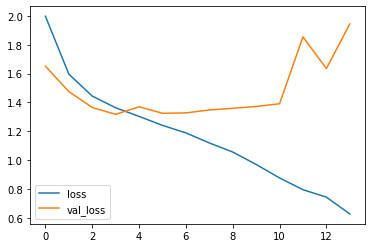

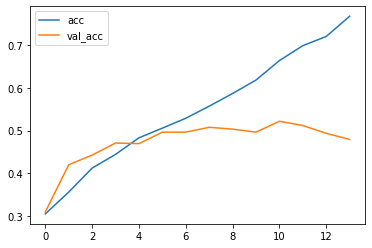

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
y_pred = np.argmax(model2D.predict(X_test2D), axis=1)

test_acc = sum(y_pred == y_test2D) / len(y_test2D)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 50%


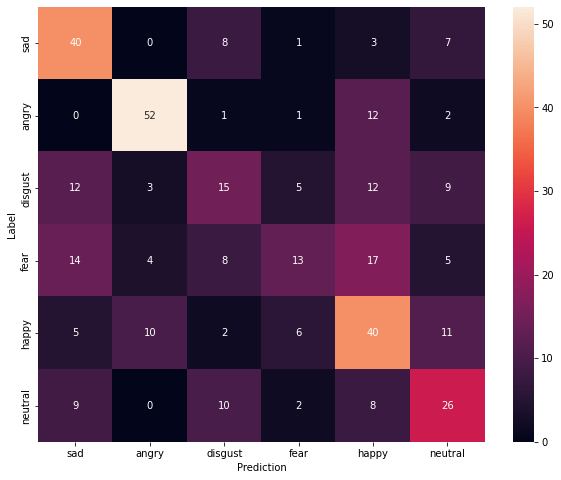

In [ ]:
classes = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
confusion_mtx_2d = tf.math.confusion_matrix(y_test2D, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_2d, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
recall_2d = np.diag(confusion_mtx_2d) / np.sum(confusion_mtx_2d, axis = 1)
precision_2d = np.diag(confusion_mtx_2d) / np.sum(confusion_mtx_2d, axis = 0)

In [ ]:
print (recall_2d)
print(precision_2d)

[0.6779661  0.76470588 0.26785714 0.21311475 0.54054054 0.47272727]
[0.5        0.75362319 0.34090909 0.46428571 0.43478261 0.43333333]


In [ ]:
print(np.mean(recall_2d))
print(np.mean(precision_2d))

0.4894852823785289
0.48782232260493136


# 4. Big Picture

In [ ]:

# calculates precision for 1:100 dataset with 90 tp and 30 fp
from sklearn.metrics import precision_score

# calculates recall for 1:100 dataset with 90 tp and 10 fn
from sklearn.metrics import recall_score

In [ ]:
precision_1d = precision_score(y_test, y_pred, average='weighted')
print('Precision: %.3f' % precision_1d)

Precision: 0.494


In [ ]:
precision_2d = precision_score(y_test2D, y_pred, average='weighted')
print('Precision: %.3f' % precision_2d)

Precision: 0.494


In [ ]:
recall_1d = recall_score(y_test, y_pred, average='weighted')
print('Recall: %.3f' % recall_1d)

Recall: 0.499


In [ ]:
recall_2d = recall_score(y_test2D, y_pred, average='weighted')
print('Recall: %.3f' % recall_2d)

Recall: 0.499


In [ ]:
f1score_1d = f1_score(y_test, y_pred, average = 'weighted')
print('F1 score: %f' % f1score_1d)

F1 score: 0.484530


In [ ]:
f1score_2d = f1_score(y_test2D, y_pred, average = 'weighted')
print('F1 score: %f' % f1score_2d)

F1 score: 0.484530


In [ ]:
def get_most_confused(matrix):
  len=matrix.shape[0]
  arr = np.zeros((len, 1))
  for i in range(len):
    for j in range(len):
      if i != j:
        arr[i] = arr[i] + matrix[i][j]
    for j in range(len):
      if i != j:
        arr[i] = arr[i] + matrix[j][i]
  most_confused = np.argmax(arr)
  return most_confused

In [ ]:
most_confused_1d = get_most_confused(confusion_mtx)
print('Most confused: %f' % most_confused_1d)

Most confused: 4.000000


In [ ]:
most_confused_2d = get_most_confused(confusion_mtx_2d)
print('Most confused: %f' % most_confused_2d)

Most confused: 4.000000
